# Sistem Rekomendasi Buku berbasis *Content-Based Filtering* dengan *Cosine Similarity*

Seiring dengan meroketnya eksistensi platform streaming seperti Netflix, YouTube, Spotify, dan sebagainya, komunitas pecinta semakin nampak semakin terlepas dari perhatian. Platform besar yang disebutkan tadi memiliki sistem rekomendasi yang mampu memberikan rekomendasi bagi para penggunanya, dan sistem rekomendasi serupa mampu diaplikasikan untuk buku. Tidak hanya untuk komunitas pembaca, namun juga untuk para penulis muda yang ide kreatifnya tak terjamah oleh khalayak luas. Maka dari itu, dikembangkanlah suatu sistem rekomendasi berbasis **Content-Based Filtering** menggunakan **Cosine Similarity**. Sistem ini bertujuan memberikan rekomendasi yang relevan berdasarkan preferensi pengguna, serta kemiripan antar buku.

Sistem ini memanfaatkan informasi seperti skor rating, penulis, serta bahasa dari tiap karya buku untuk menghasilkan rekomendasi yang personal. Dengan sistem ini, platform streaming buku diharapkan mampu membantu pecinta buku menjumpai lebih banyak buku seperti kesukaan mereka, meningkatkan popularitas buku yang belum terkenal, dan mendukung pertumbuhan komunitas dan bisnis.

## Import Library yang Dibutuhkan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer,MinMaxScaler, OneHotEncoder, LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
import re
warnings.filterwarnings('ignore')

## Data Loading & Understanding

### Download Data

Langkah pertama adalah mengunduh data. Namun sebelum mengunduh data, kita perlu mengunggah kredensial akun Kaggle kita sebagai sumber dataset yang kita gunakan, agar kita bisa mengambil data dari Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"satriaadifirmansyah","key":"006dbae515ec28c175ef6ddd5a715a10"}'}

In [3]:
!pip install kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Setelah itu, barulah kita bisa mengunduh dan membuka dataset dari Kaggle ini. Dataset didapat dari link [berikut](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)

In [4]:
!kaggle datasets download -d jealousleopard/goodreadsbooks

Dataset URL: https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks
License(s): CC0-1.0
  0% 0.00/622k [00:00<?, ?B/s]
100% 622k/622k [00:00<00:00, 857MB/s]


In [5]:
!unzip goodreadsbooks.zip

Archive:  goodreadsbooks.zip
  inflating: books.csv               


Hanya ada 1 file dalam dataset, yaitu **books.csv**

### Load Data

**Intip isi dataset**

In [6]:
book = pd.read_csv('books.csv', on_bad_lines='skip')
book.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


**Periksa isi dataset, jumlah, serta tipe datanya**

In [7]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


Terdapat **11123** baris data, dengan 11 kolom. Menurut informasi dari sumber data, berikut adalah detail dari isi tiap kolom:

1. `bookID`: Identifikasi unik tiap buku
2. `title`: Judul dari tiap buku
3. `authors`: Penulis dari tiap buku. Pada beberapa baris data, terdapat lebih dari dua penulis buku.
4. `average_rating`: skor rating rerata dari tiap buku
5. `isbn`: Nomor ISBN tiap buku, mirip seperti bookID, namun lebih seperti nomor serial.
6. `isbn13`: Nomor ISBN, namun dalam 13 digit
7. `language_code`: Bahasa dari karya buku yang dituliskan.
8. `num_pages`: Jumlah halaman dari tiap buku
9. `ratings_count`: Jumlah rating yang diterima tiap buku
10. `text_reviews_count`: Jumlah review dalam bentuk teks yang diterima tiap buku
11. `publication_date`: Tanggal terbitnya tiap buku
12. `publisher`: Penerbit buku

Jika diperhatikan, `publication_date` masih dalam tipe data yang keliru. Sebelumnya, kita ubah dahulu ke format `datetime`

In [8]:
book['publication_date'] = pd.to_datetime(book['publication_date'], errors = 'coerce')
book['publication_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11123 entries, 0 to 11122
Series name: publication_date
Non-Null Count  Dtype         
--------------  -----         
11121 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 87.0 KB


### Pemeriksaan Data *Null* dan *Duplicate*

Selanjutnya, kita periksa baris yang bervalue *null*

Proses pengecekan nilai yang hilang dibutuhkan agar mengetahui berapa banyak jumlah nilai yang tidak ada di dalam dataset, hal ini berfungsi sebagai langkah awal dalam melakukan pembersihan data (data cleaning). Dengan mengetahui jumlah nilai yang hilang, kita dapat memutuskan langkah selanjutnya, seperti:

- Menghapus baris atau kolom yang memiliki nilai yang hilang jika jumlahnya sangat besar dan tidak relevan dengan analisis.
- Mengisi nilai yang hilang dengan nilai pengganti seperti rata-rata (mean), median, modus, atau menggunakan teknik imputasi lain yang sesuai dengan jenis data dan tujuan analisis.
- Menangani nilai yang hilang secara selektif berdasarkan pentingnya kolom atau baris tertentu, terutama jika data tersebut diperlukan untuk model prediksi.

In [9]:
book.isnull().sum()

,0
bookID,0
title,0
authors,0
average_rating,0
isbn,0
isbn13,0
language_code,0
num_pages,0
ratings_count,0
text_reviews_count,0


Ada dua baris dengan value *null* di `publication_date`. Karena sangat sedikit, kita bisa hapus saja baris tersebut.

Namun sebelumnya, kita periksa dulu apakah ada value yang duplikat.

In [10]:
book.duplicated().sum()

np.int64(0)

Ternyata tidak ada value duplikat. Maka, kita bisa lanjut ke menghapus value yang null tadi.

In [11]:
book.dropna(inplace=True)
book.isnull().sum()

,0
bookID,0
title,0
authors,0
average_rating,0
isbn,0
isbn13,0
language_code,0
num_pages,0
ratings_count,0
text_reviews_count,0


Sudah tidak ada value yang *null*

### Exploratory Data Analysis

Kita coba lihat statistika dari data numerikal yang ada.

In [12]:
book.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,publication_date
count,11121.000000,11121.000000,1.112100e+04,11121.000000,1.112100e+04,11121.000000,11121
mean,21307.774301,3.934058,9.759876e+12,336.343944,1.794512e+04,542.118874,2000-08-29 03:05:33.099541504
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000,1900-01-01 00:00:00
25%,10270.000000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000,1998-07-17 00:00:00
50%,20264.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000,2003-03-01 00:00:00
75%,32104.000000,4.140000,9.780872e+12,416.000000,4.996000e+03,238.000000,2005-10-01 00:00:00
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000,2020-03-31 00:00:00
std,13093.542472,0.350513,4.430156e+11,241.129968,1.125091e+05,2576.845134,NaN


**Melihat distribusi rating buku**

Pengecekan distribusi rating buku penting untuk memahami bagaimana pengguna memberikan penilaian, mendeteksi bias atau ketidakseimbangan dalam penilaian, serta menemukan outliers yang dapat memengaruhi akurasi sistem rekomendasi.

In [13]:
book['average_rating'].value_counts()

,count
average_rating,
4.00,219
3.96,194
4.02,178
3.94,176
4.07,172
...,...
2.63,1
4.88,1
4.83,1


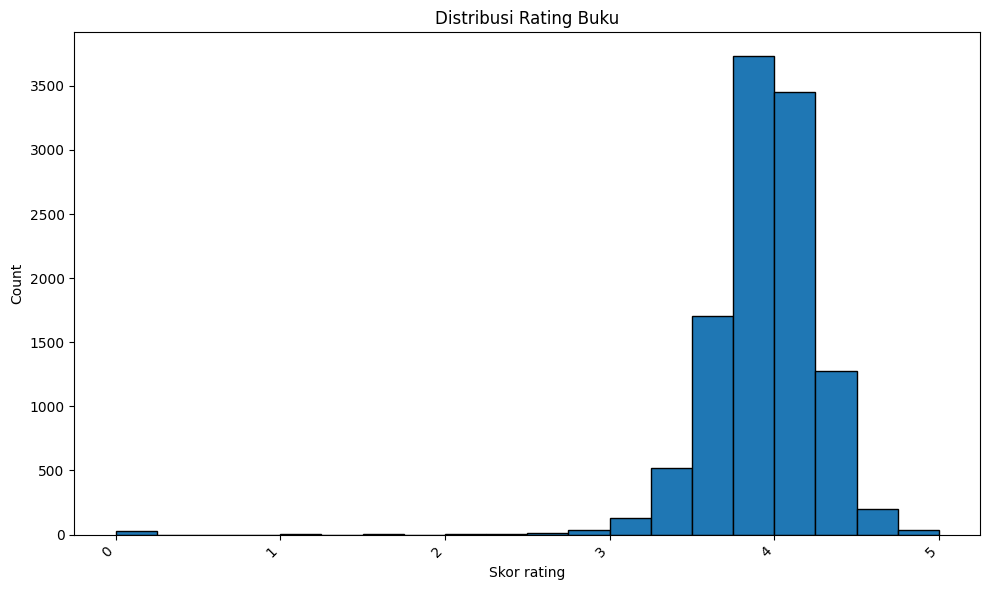

In [14]:
plt.figure(figsize=(10, 6))
book['average_rating'].astype(float).plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribusi Rating Buku')
plt.xlabel('Skor rating')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Data Skor rating memiliki **Distribusi Normal**, dalam grafik diatas, skor buku yang paling banyak berada di antara skor antara 3.5 hingga 4.5. Banyak buku yang mendapatkan skor di atas rerata yaitu 3.93

**Melihat Distribusi jumlah karya buku berdasarkan Penulis**

Pengecekan distribusi jumlah karya buku berdasarkan penulis penting untuk melihat seberapa banyak jumlah penulis yang ada dalam dataset, serta jumlah karyanya masing-masing.

In [15]:
book['authors'].value_counts()

,count
authors,
P.G. Wodehouse,40
Stephen King,40
Rumiko Takahashi,39
Orson Scott Card,35
Agatha Christie,33
...,...
Mikal Gilmore,1
Thich Nhat Hanh/Arnold Kotler/Dalai Lama XIV,1
Alex Austin,1


Karena ada terlalu banyak penulis dalam dataset, serta adanya 2 hingga 3 penulis dalam satu karya, maka dipisahkan terlebih dahulu kolom penulis ini ke dalam bentuk list. Kemudian, kita bisa lihat lebih jelas distribusinya dengan mengambil 50 penulis dengan karya terbanyak.

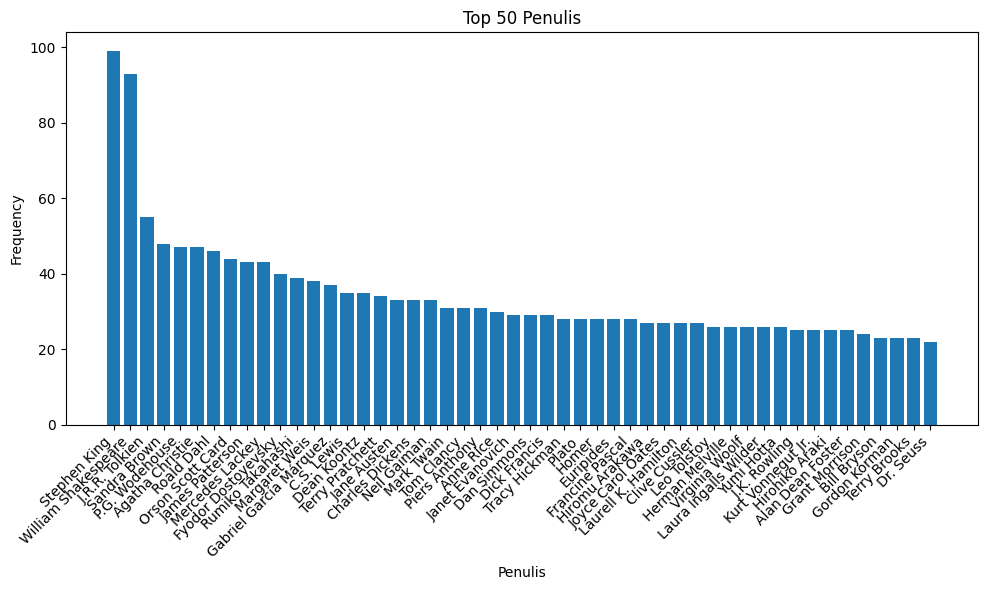

In [16]:
from collections import Counter
author_list = book['authors'].dropna().str.split('/').sum()
author_counts = Counter(author_list).most_common(50)
author, counts = zip(*author_counts)
plt.figure(figsize=(10, 6))
plt.bar(author, counts)
plt.title("Top 50 Penulis")
plt.xlabel("Penulis")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Melihat Distribusi jumlah karya buku berdasarkan Penerbit**

Pengecekan distribusi jumlah karya buku berdasarkan penulis penting untuk melihat seberapa banyak jumlah penerbit yang ada dalam dataset, serta jumlah karya yang diterbitkan oleh tiap penerbit.

In [17]:
book['publisher'].value_counts()

,count
publisher,
Vintage,318
Penguin Books,261
Penguin Classics,184
Mariner Books,150
Ballantine Books,144
...,...
Amistad Press,1
Panamericana Editorial,1
Suma,1


Mirip seperti jumlah penulis yang terlalu banyak, maka kita ambil 50 penerbit dengan karya terbitan terbanyak.

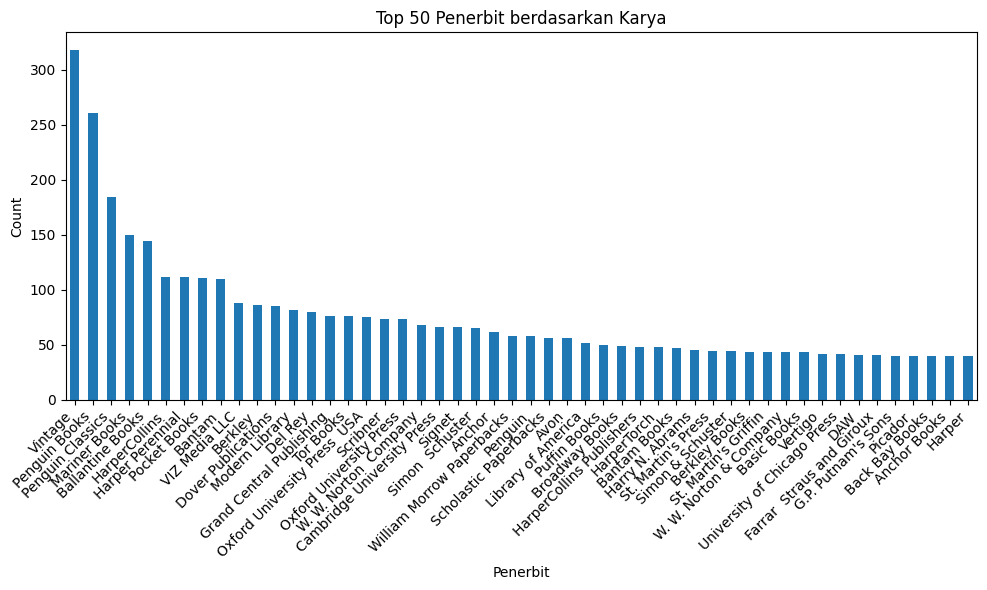

In [18]:
plt.figure(figsize=(10, 6))
book['publisher'].value_counts().head(50).plot(kind='bar')
plt.title('Top 50 Penerbit berdasarkan Karya')
plt.xlabel('Penerbit')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Melihat Distribusi jumlah karya buku berdasarkan Bahasa Karya**

Pengecekan distribusi jumlah karya buku berdasarkan Bahasa penting untuk melihat seberapa banyak Bahasa buku yang ada dalam dataset, serta jumlah bahasa dari karya yang diterbitkan.

In [19]:
book['language_code'].value_counts()

,count
language_code,
eng,8907
en-US,1408
spa,218
en-GB,214
fre,143
ger,99
jpn,46
mul,19
zho,14


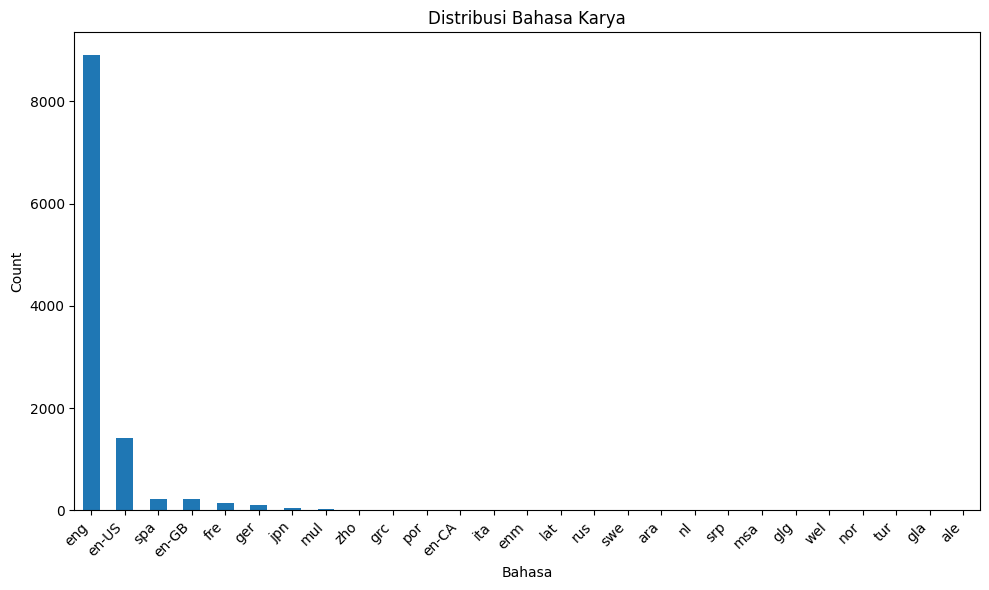

In [20]:
plt.figure(figsize=(10, 6))
book['language_code'].value_counts().plot(kind='bar')
plt.title('Distribusi Bahasa Karya')
plt.xlabel('Bahasa')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Berbeda dari yang lain, jumlah bahasa karya tidak terlalu banyak, jadi kita bisa plot distribusinya semua. Bisa dilihat, mayoritas bahasa hasil karya ada dalam bahasa Inggris UK, bahasa Inggris USA, serta bahasa Spanyol.

## Data Preparation

Data hilang sudah dibersihkan di awal, namun masih diperlukan pemisahan nama dalam karya yang ditulis oleh lebih dari satu orang.

Maka dari itu, dilakukanlah pemisahan nama ini menjadi dalam bentuk list, dari isi yang awalnya diberi separator '/'

In [21]:
book['authors'] = book['authors'].str.split('/')
book.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[J.K. Rowling, Mary GrandPré]",4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]",4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,[J.K. Rowling],4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[J.K. Rowling, Mary GrandPré]",4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[J.K. Rowling, Mary GrandPré]",4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic


Setelah itu, dilakukan penskalaan skor rating karya buku dengan MinMax Scaler

In [22]:
mmscaler = MinMaxScaler()

book['average_rating'] = mmscaler.fit_transform(book[['average_rating']])
book.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[J.K. Rowling, Mary GrandPré]",0.914,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]",0.898,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,[J.K. Rowling],0.884,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[J.K. Rowling, Mary GrandPré]",0.912,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[J.K. Rowling, Mary GrandPré]",0.956,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic


Setelah itu, dilakukanlah LabelEncode terhadap data `language_code`

In [23]:
le = LabelEncoder()
language_encoded = le.fit_transform(book[['language_code']])
book.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[J.K. Rowling, Mary GrandPré]",0.914,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]",0.898,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,[J.K. Rowling],0.884,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[J.K. Rowling, Mary GrandPré]",0.912,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[J.K. Rowling, Mary GrandPré]",0.956,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic


Terakhir, menggunakan **MultiLabelBinarizer** untuk mengonversi data penulis buku yang berupa list menjadi format biner yang dapat digunakan untuk analisa lebih lanjut

In [24]:
mlb = MultiLabelBinarizer()
authors_encoded = mlb.fit_transform(book['authors'])

In [25]:
print(mlb.classes_)
print(authors_encoded[:5])

['A. Bartlett Giamatti' 'A. Elizabeth Delany' 'A. Merritt' ... '神尾葉子'
 '荒川弘' '趙丕慧']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Setelah persiapan data selesai, dilakukanlah langkah terakhir yaitu penggabungan fitur-fitur tertentu menjadi fitur yang digunakan untuk menghasilkan rekomendasi.

In [26]:
average_rating_2d = book['average_rating'].values.reshape(-1, 1)
language_encoded_2d = language_encoded.reshape(-1, 1)

fitur_matriks = np.hstack(
    [authors_encoded, language_encoded_2d, average_rating_2d]
)

print(fitur_matriks[:5])

[[0.    0.    0.    ... 0.    5.    0.914]
 [0.    0.    0.    ... 0.    5.    0.898]
 [0.    0.    0.    ... 0.    5.    0.884]
 [0.    0.    0.    ... 0.    5.    0.912]
 [0.    0.    0.    ... 0.    5.    0.956]]


## Modelling

Setelah fitur Matriks sudah mencakup berbagai informasi yang dapat digunakan, langkah selanjutnya adalah menghitung cosine similarity antar buku.

In [27]:
# Menghitung Cosine Similarity dari matrix fitur
combined_similarity = cosine_similarity(fitur_matriks)

In [28]:
print(combined_similarity[:5])

[[1.         0.99999553 0.98185698 ... 0.9448756  0.94457274 0.95241345]
 [0.99999553 1.         0.98185041 ... 0.94490235 0.94462695 0.95279705]
 [0.98185698 0.98185041 1.         ... 0.96239847 0.96214246 0.97075747]
 [0.99999993 0.99999658 0.98185664 ... 0.94487941 0.94457997 0.95246184]
 [0.99996935 0.99994149 0.98183263 ... 0.94476551 0.94439071 0.95136811]]


Fungsi berikut dibuat agar bisa mencari rekomendasi berdasarkan fitur-fitur dalam matriks, dan sesuai yang ada dalam judul buku yang dicari.

In [29]:
def recommend_books_multi_feature(book_name, top_n=10):
  index = book[book['title'] == book_name].index[0]

  similarity_scores = list(enumerate(combined_similarity[index]))
  similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
  similar_book_indices = [i[0] for i in similarity_scores[1:top_n+1]]
  return book.iloc[similar_book_indices][['title', 'average_rating', 'language_code', 'authors']]

## Mencari Top - N Rekomendasi


In [30]:
multi_feature_recommended_book = recommend_books_multi_feature("The Road to Dune", top_n=10)

similar_book_indices = multi_feature_recommended_book.index

normalized_ratings = multi_feature_recommended_book[['average_rating']].values
normalized_authors = multi_feature_recommended_book['authors'].values
normalized_language = multi_feature_recommended_book['language_code'].values

# Apply the inverse transform to get original ratings
original_ratings = mmscaler.inverse_transform(normalized_ratings).flatten()
original_authors = mlb.inverse_transform(authors_encoded[similar_book_indices])
original_language = le.inverse_transform(language_encoded[similar_book_indices])

# Update the 'average_rating' column in the DataFrame with the original values
multi_feature_recommended_book['average_rating'] = original_ratings
multi_feature_recommended_book['authors'] = original_authors
multi_feature_recommended_book['language_code'] = original_language

In [31]:
from IPython.display import display
display(multi_feature_recommended_book)

,title,average_rating,language_code,authors
5555,The Battle Of Corrin (Legends of Dune #3),3.74,eng,"(Brian Herbert, Kevin J. Anderson)"
5556,House Corrino (Prelude to Dune #3),3.68,eng,"(Brian Herbert, Kevin J. Anderson)"
5557,House Harkonnen (Prelude to Dune #2),3.67,eng,"(Brian Herbert, Kevin J. Anderson)"
5554,Hunters of Dune (Dune Chronicles #7),3.65,eng,"(Brian Herbert, Kevin J. Anderson)"
10435,Sandworms of Dune (Dune Chronicles #8),3.64,eng,"(Doug Stanton,)"
67,Dune Messiah (Dune Chronicles #2),3.88,eng,"(Frank Herbert,)"
69,Heretics of Dune (Dune Chronicles #5),3.86,eng,"(Frank Herbert,)"
71,Heretics of Dune (Dune Chronicles #5),3.86,eng,"(Frank Herbert,)"
66,Chapterhouse: Dune (Dune Chronicles #6),3.91,eng,"(Frank Herbert,)"
65,God Emperor of Dune (Dune Chronicles #4),3.84,eng,"(Frank Herbert,)"


Terlihat sistem rekomendasi berhasil memberikan 10 rekomendasi buku yang sesuai dan mirip dengan buku **The Road to Dune**. Bisa diperhatikan, beberapa kesamaan yang terlihat adalah dari skor yang sama, penulis yang sama, serta bahasa karya yang sama.

## Metrik Evaluasi

Dalam Sistem Rekomendasi ini, Evaluasi akan dilakukan berdasarkan data tipe yang dihasilkan dari sistem rekomendasi menggunakan metrik tertentu

#### Precision
1. **Precision**  
   Mengukur proporsi dari anime yang direkomendasikan yang relevan berdasarkan ground truth.

   $$
   \text{Precision} = \frac{\text{Jumlah rekomendasi yang relevan}}{\text{Jumlah total rekomendasi}}
   $$


Berikut adalah blok kode untuk mencari nilai Precision

In [32]:
def calculate_precision(input_book_name, recommended_books_df):
  # Get the features of the input book
  input_book = book[book['title'] == input_book_name].iloc[0]
  input_authors = set([author.strip() for sublist in input_book['authors'] for author in (sublist.split('/') if isinstance(sublist, str) else sublist)])
  input_language = input_book['language_code']
  input_rating = input_book['average_rating']

  relevant_count = 0
  total_recommendations = len(recommended_books_df)

  # Iterate through recommended books to check for relevance
  for index, row in recommended_books_df.iterrows():
    recommended_authors = set([author.strip() for sublist in row['authors'] for author in (sublist.split('/') if isinstance(sublist, str) else sublist)])
    recommended_language = row['language_code']
    recommended_rating = row['average_rating']

    # Define relevance: shares an author or has the same language
    if input_authors.intersection(recommended_authors) or input_language == recommended_language:
       relevant_count += 1

  precision = relevant_count / total_recommendations if total_recommendations > 0 else 0
  return precision

# Get recommendations for a book
input_book_title = "The Road to Dune"
recommended_books = recommend_books_multi_feature(input_book_title, top_n=10)

# Calculate and print precision
precision_score = calculate_precision(input_book_title, recommended_books)
print(f"Precision for '{input_book_title}': {precision_score:.2f}")

Precision for 'The Road to Dune': 1.00


Adapun untuk buku yang ingin dicari rekomendasinya, **The Road to Dune** ditulis oleh Frank Herbert, Brian Herbert, dan Kevin J. Anderson. Memiliki skor rating 3,88 dan berbahasa Inggris. Presisi yang didapatkan adalah (10/10) =  1, atau 100% Presisi, karena sistem berhasil memberikan rekomendasi yang relevan terhadap buku.